# Land Parcel Extraction using Edge Detection model

> * 🔬 Data Science
> * 🥠 Deep Learning and edge detection

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export land parcel boundaries data](#Export-land-parcel-boundaries-data)
* [Prepare data](#Prepare-data)
* [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
* [Part 1 - Model training](#Part-1---Model-training)
  * [Load BDCN or HED edge detector model architecture](#Load-BDCN-or-HED-edge-detector-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model on the data](#Fit-the-model-on-the-data)
  * [Plot losses](#Plot-losses)
  * [Visualize results](#Visualize-results)
  * [Save the model](#Save-the-model)
  * [Compute evaluation metrics](#Compute-evaluation-metrics)
* [Part 2 - Deploying model, and extraction of parcels in imagery at scale](#Part-2---Deploying-model,-and-extraction-of-parcels-in-imagery-at-scale)
  * [Generate a classified raster using classify pixels using deep learning tool](#Generate-a-classified-raster-using-classify-pixels-using-deep-learning-tool)
  * [Post-processing workflow using modelbuilder](#Post-processing-workflow-using-modelbuilder)
  * [Final output](#Final-output)
* [References](#References)

## Introduction

High-resolution remote sensing images provide useful spatial information for plot delineation; however, manual processing is time-consuming.  Automatically extracting visible cadastral boundaries combined with (legal) adjudication and incorporation of local knowledge from human operators offers the potential to improve current cadastral mapping approaches in terms of time, cost, accuracy, and acceptance.

This sample shows how `ArcGIS API for Python` can be used to train a deep learning edge detection model to extract parcels from satellite imagery and thus more efficient approaches for cadastral mapping.

In this workflow we will basically have three steps.

- Export training data
- Train a model
- Deploy model and extract land parcels

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path

import arcgis
from arcgis import GIS
from arcgis.learn import BDCNEdgeDetector, HEDEdgeDetector, prepare_data

## Connect to your GIS

In [2]:
gis = GIS("home")
ent_gis = GIS('https://pythonapi.playground.esri.com/portal')

## Export land parcel boundaries data

Training data can be exported by using the `Export Training Data For Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The training data consisted of polyline buffered feature class with a 'class' attribute. For this example, we prepared training data in `Classified Tiles` format using a `chip_size` of 400px and `cell_size` of 20cm in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview).

- `Input Raster` : Esri World Imagery
- `Input Feature Class or Classified Raster` : buffered polyline with class attribute
- `Class Value Field` : field in the attributes containing class
- `Tile Size X & Tile Size Y` : 400
- `Stride X & Stride Y` : 128
- `Reference System` : Map space
- `Meta Data Format` : Classified tiles
- `Environments` : Set optimum Cell Size, Processing Extent 

Raster and parcels data used for exporting the training dataset are provided below

In [3]:
training_area_raster = ent_gis.content.get('8202ffe4fcaf4ba9bfefe2154f98e7b8')
training_area_raster

<Item title:"train_area_edgedetection_tif" type:Imagery Layer owner:api_data_owner>

<Item title:"Parcels training data edge detection model" type:Feature Layer Collection owner:api_data_owner>
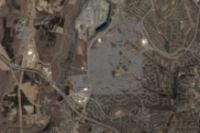

In [4]:
parcel_training_polygon = gis.content.get('ac0e639d6e9b43328605683efb37ff56')
parcel_training_polygon

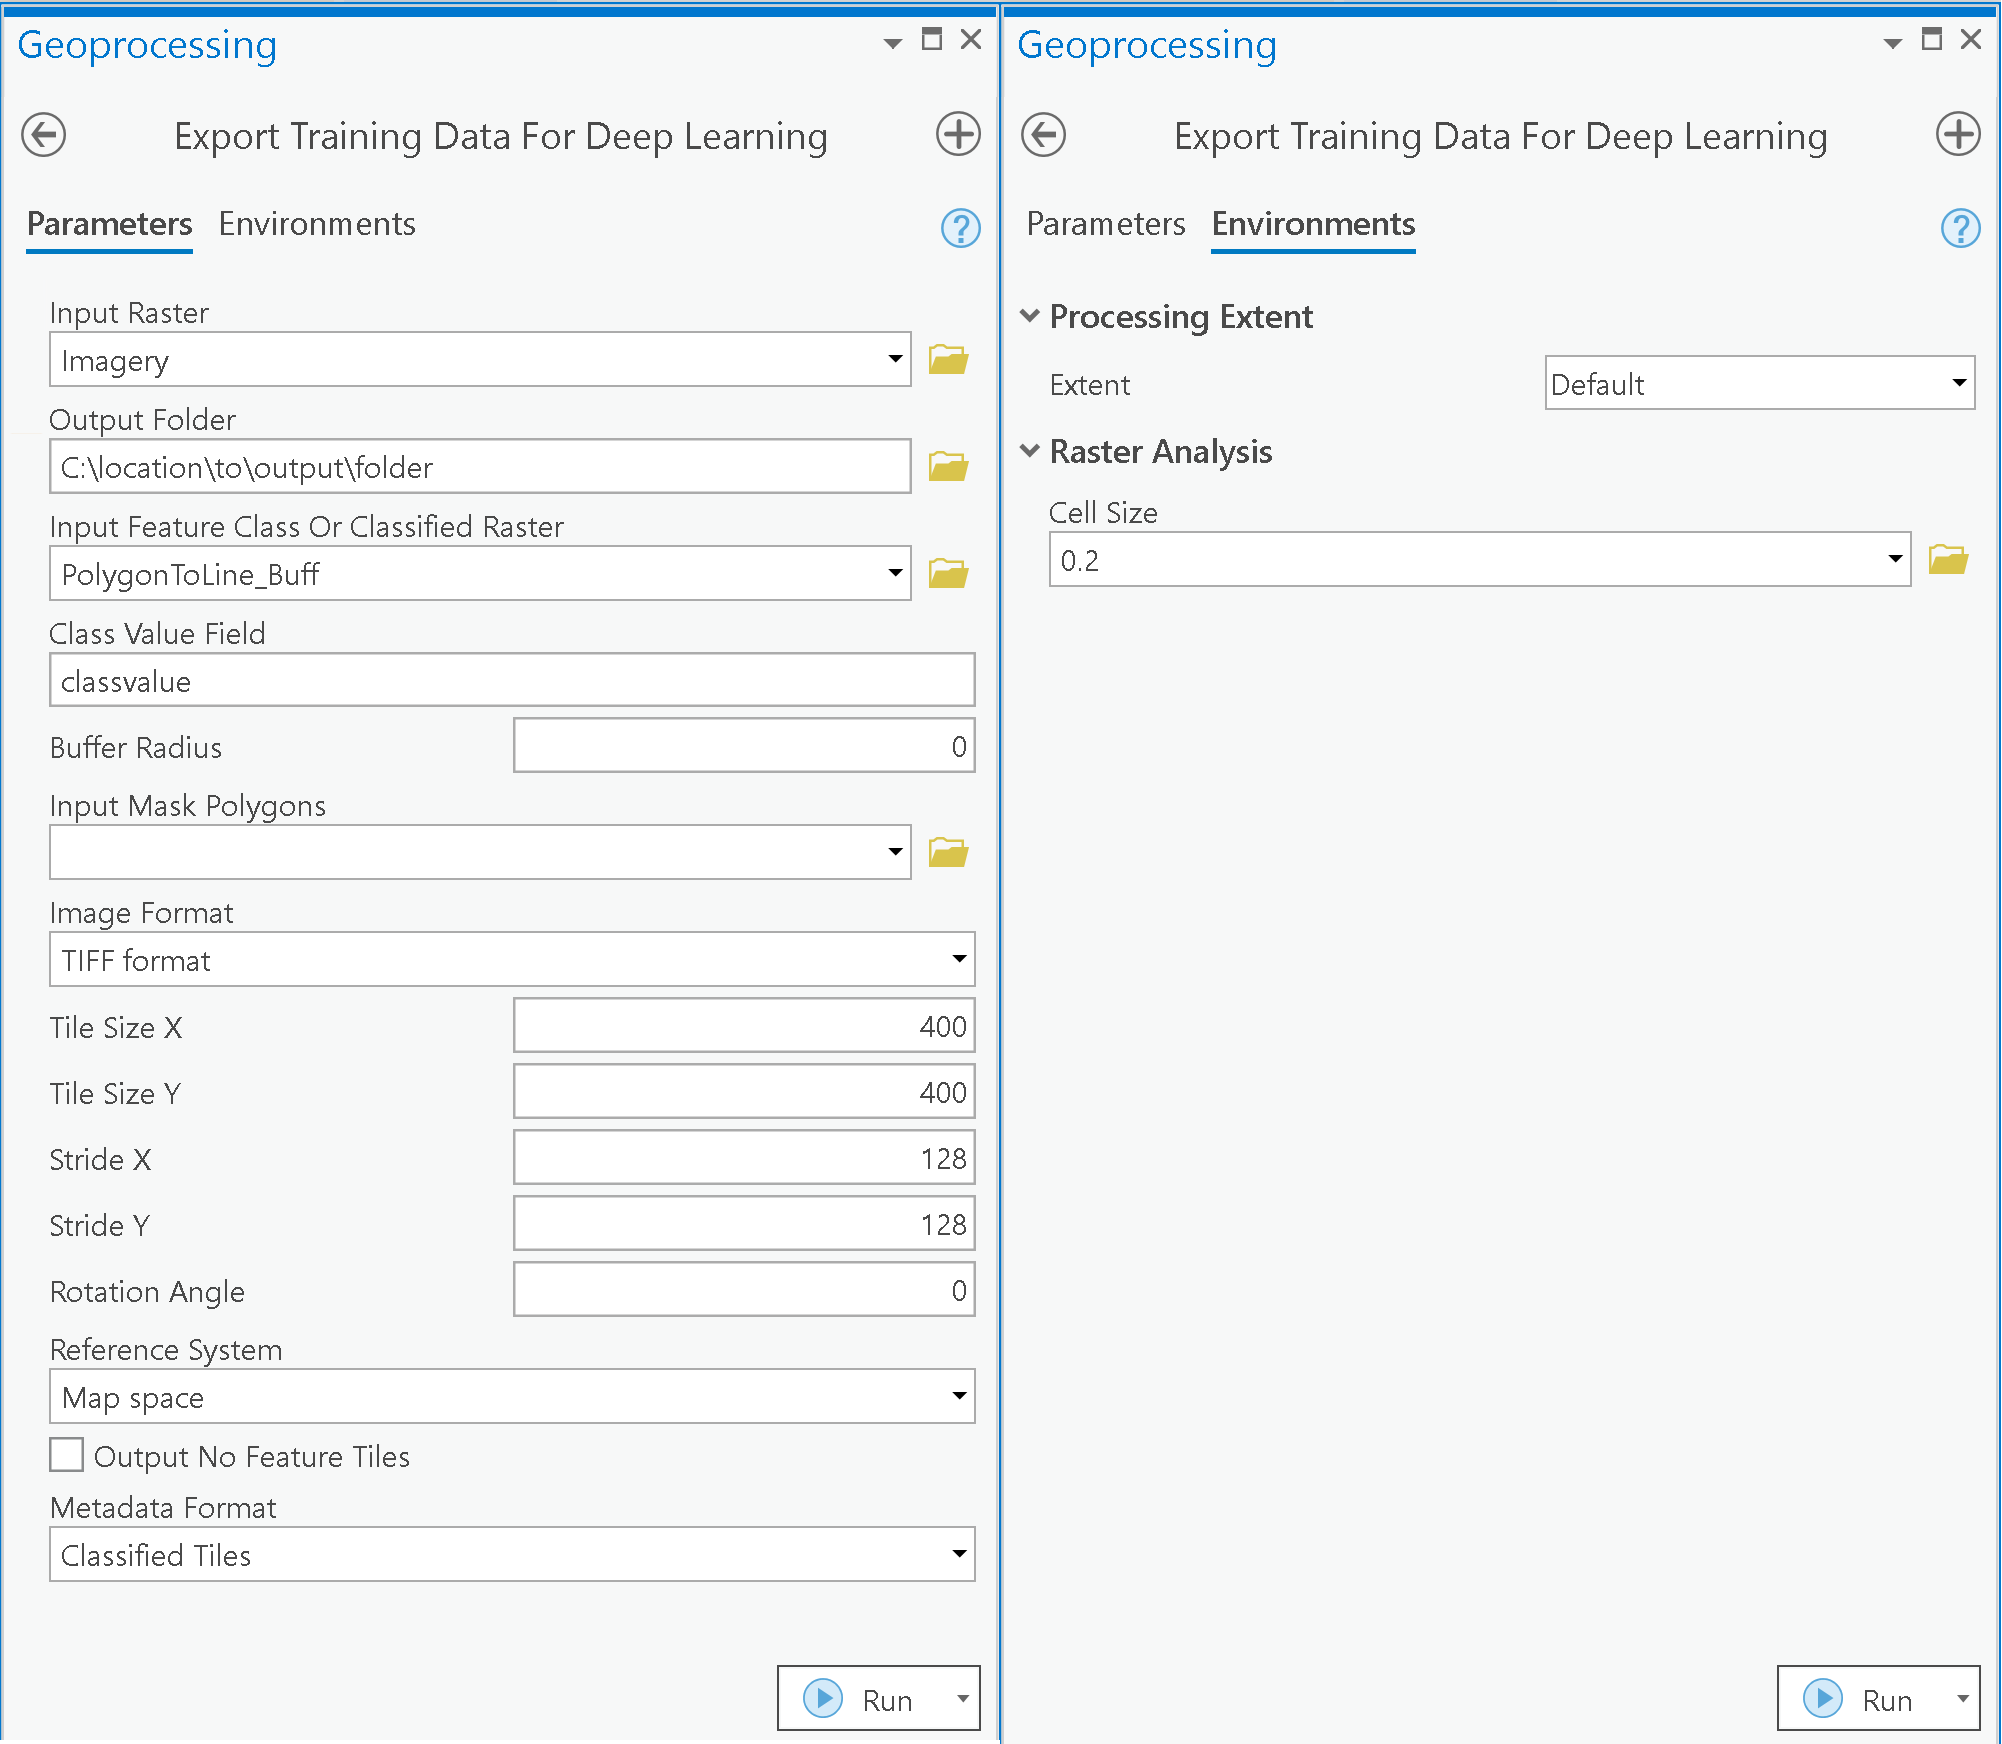

`arcpy.ia.ExportTrainingDataForDeepLearning("Imagery", r"C:\sample\Data\Training Data 400px 20cm", "land_parcels_training_buffered.shp", "TIFF", 400, 400, 128, 128, "ONLY_TILES_WITH_FEATURES", "Classified_Tiles", 0, None, 0, 0, "MAP_SPACE", "NO_BLACKEN", "Fixed_Size")`

This will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our training data.

## Prepare data

Alternatively, we have provided a subset of training data containing a samples below and the parcel training polygon used for exporting data. You can use the data directly to run the experiments.

<Item title:"land_parcel_extraction_using_edge_detection_deep_learning_model" type:Image Collection owner:api_data_owner>
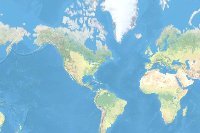

In [5]:
training_data = gis.content.get('013a892c05954b5b808b0b9497adca21')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [8]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

We would specify the path to our training data and a few parameters.

- `path`: path of folder containing training data.
- `chip_size`: Same as per specified while exporting training data
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card.

In [9]:
data = prepare_data(data_path, batch_size=2)

## Visualize a few samples from your training data

The code below shows a few samples of our data with the same symbology as in ArcGIS Pro.

- `rows`: No of rows we want to see the results for.
- `alpha`: controls the opacity of labels(Classified imagery) over the drone imagery

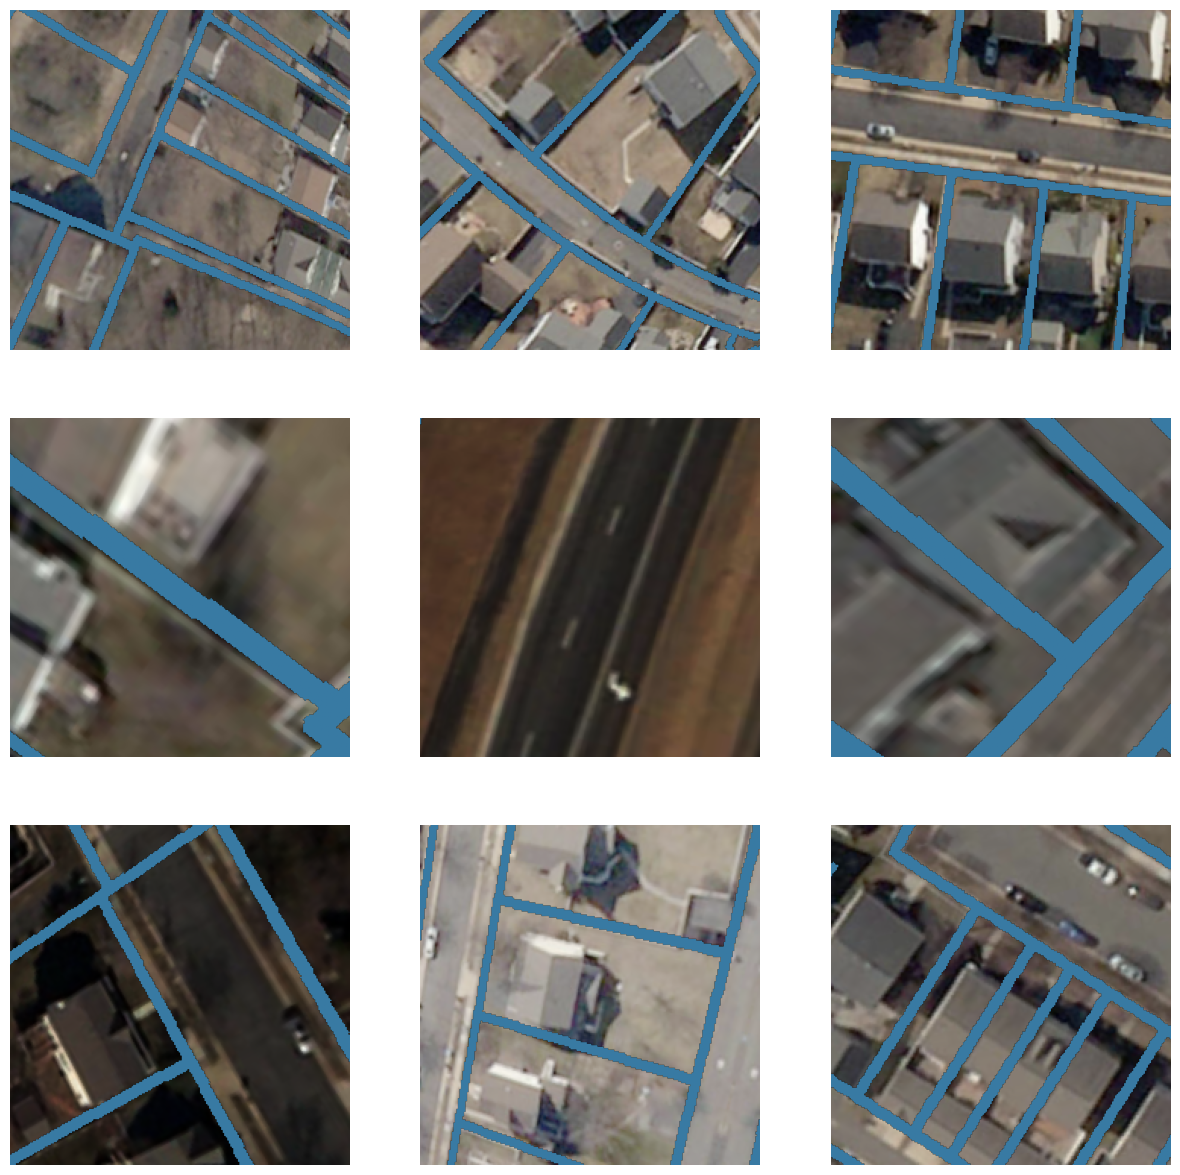

In [10]:
data.show_batch(alpha=1)

## Part 1 - Model training

### Load BDCN or HED edge detector model architecture

There are two available edge detection models in `arcgis.learn`, the `HEDEdgeDetector` and `BDCNEdgeDetector`. If backbone is not specified, by default this model will be loaded on a pretrained ResNet type backbone.

In [12]:
#model = HEDEdgeDetector(data, backbone="vgg19")

#or

model = BDCNEdgeDetector(data, backbone="vgg19")

List of supported backbones, that could be used during training.

In [13]:
model.supported_backbones

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

### Tuning for optimal learning rate

Optimization in deep learning is all about tuning 'hyperparameters'. In this step, we will find an 'optimum learning rate' for our model on the training data. Learning rate is a very important parameter, while training our model it will see the training data several times and adjust itself (the weights of the network). Too high learning rate will lead to the convergence of our model to a suboptimal solution and too low learning can slow down the convergence of our model. We can use the lr_find() method to find an optimum learning rate at which can train a robust model fast enough.

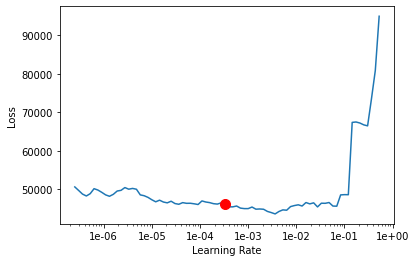

In [17]:
# Find Learning Rate
lr = model.lr_find()

In [16]:
lr

0.007585775750291836

### Fit the model on the data

To start with let us first train the model for 30 epochs. One epoch means the model will see the complete training set once and so on. If you feel the results are not satisfactory we can train it further for more number of epochs.

In [18]:
model.fit(epochs=30, lr=lr)

epoch,train_loss,valid_loss,accuracy,f1_score,dice,time
0,42379.250000,42792.605469,0.635095,0.221039,1.000000,04:13
1,41170.578125,40688.066406,0.702877,0.339028,1.000000,04:03
2,42477.429688,39820.054688,0.622671,0.364611,1.000000,04:05
3,39409.554688,37903.304688,0.663775,0.425070,1.000000,04:01
4,38365.433594,37327.031250,0.704567,0.461380,1.000000,04:02
5,38277.031250,36422.820312,0.774611,0.519772,1.000000,04:04
6,36631.902344,35825.132812,0.733576,0.512209,1.000000,04:08
7,36634.308594,35847.406250,0.692677,0.503312,1.000000,04:06
8,37351.023438,35534.578125,0.689683,0.510992,1.000000,04:02
9,36165.355469,34997.855469,0.738407,0.500707,1.000000,04:02


### Plot losses

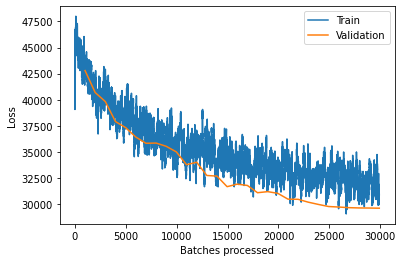

In [19]:
model.plot_losses()

### Visualize results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

We have few parameters for visualization.
- `alpha`: controls the opacity of predicted edges. Set to 1.
- `thinning`: Its a post-processsing parameters, which thins or skeletonizes the predicted edges. We will be using our own pre-processing workflow build in ArcGIS pro hence, will set it to False. As per results, this could also be set to True/False during inferencing in pro.

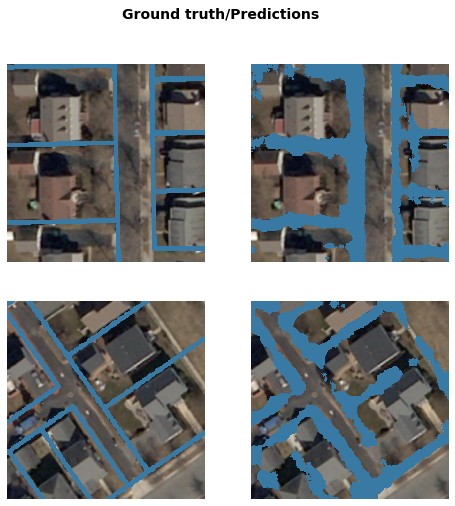

In [20]:
model.show_results(alpha=1,thinning=False)

### Save the model

We would now save the model which we just trained as a `Deep Learning Package` or `.dlpk` format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. For this sample, we will be using this model in ArcGIS Pro to extract land parcels.

We will use the `save()` method to save the model and by default, it will be saved to a folder 'models' inside our training data folder.

In [ ]:
model.save("edge_model_e30")

We can observe some room for further improvement, so we trained the model for further 70 epochs. The deployment and results from the model trained for 100 epochs are shown upcoming section.

## Part 2 - Deploying model, and extraction of parcels in imagery at scale

The deep learning package saved in the previous step can be used to extract classified raster using the `Classify Pixels Using Deep Learning` tool. Further, the classified raster is regularised and finally converted to a vector Polygon layer. The post-processing steps use advanced ArcGIS geoprocessing tools to remove unwanted artifacts in the output. 

As the model has been trained on a limited amount of data, it is expected to only work well in nearby areas and similar geographies.

### Generate a classified raster using classify pixels using deep learning tool

We will use the saved model to detect objects using the `Classify pixels Using Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). For this sample, we will use world imagery to delineate boundaries.

Raster used for testing the model is provided below

In [4]:
test_area_raster = ent_gis.content.get('481f2ba520274f0fabfe470d2c8def39')
test_area_raster

<Item title:"test_raster_tif" type:Imagery Layer owner:api_data_owner>

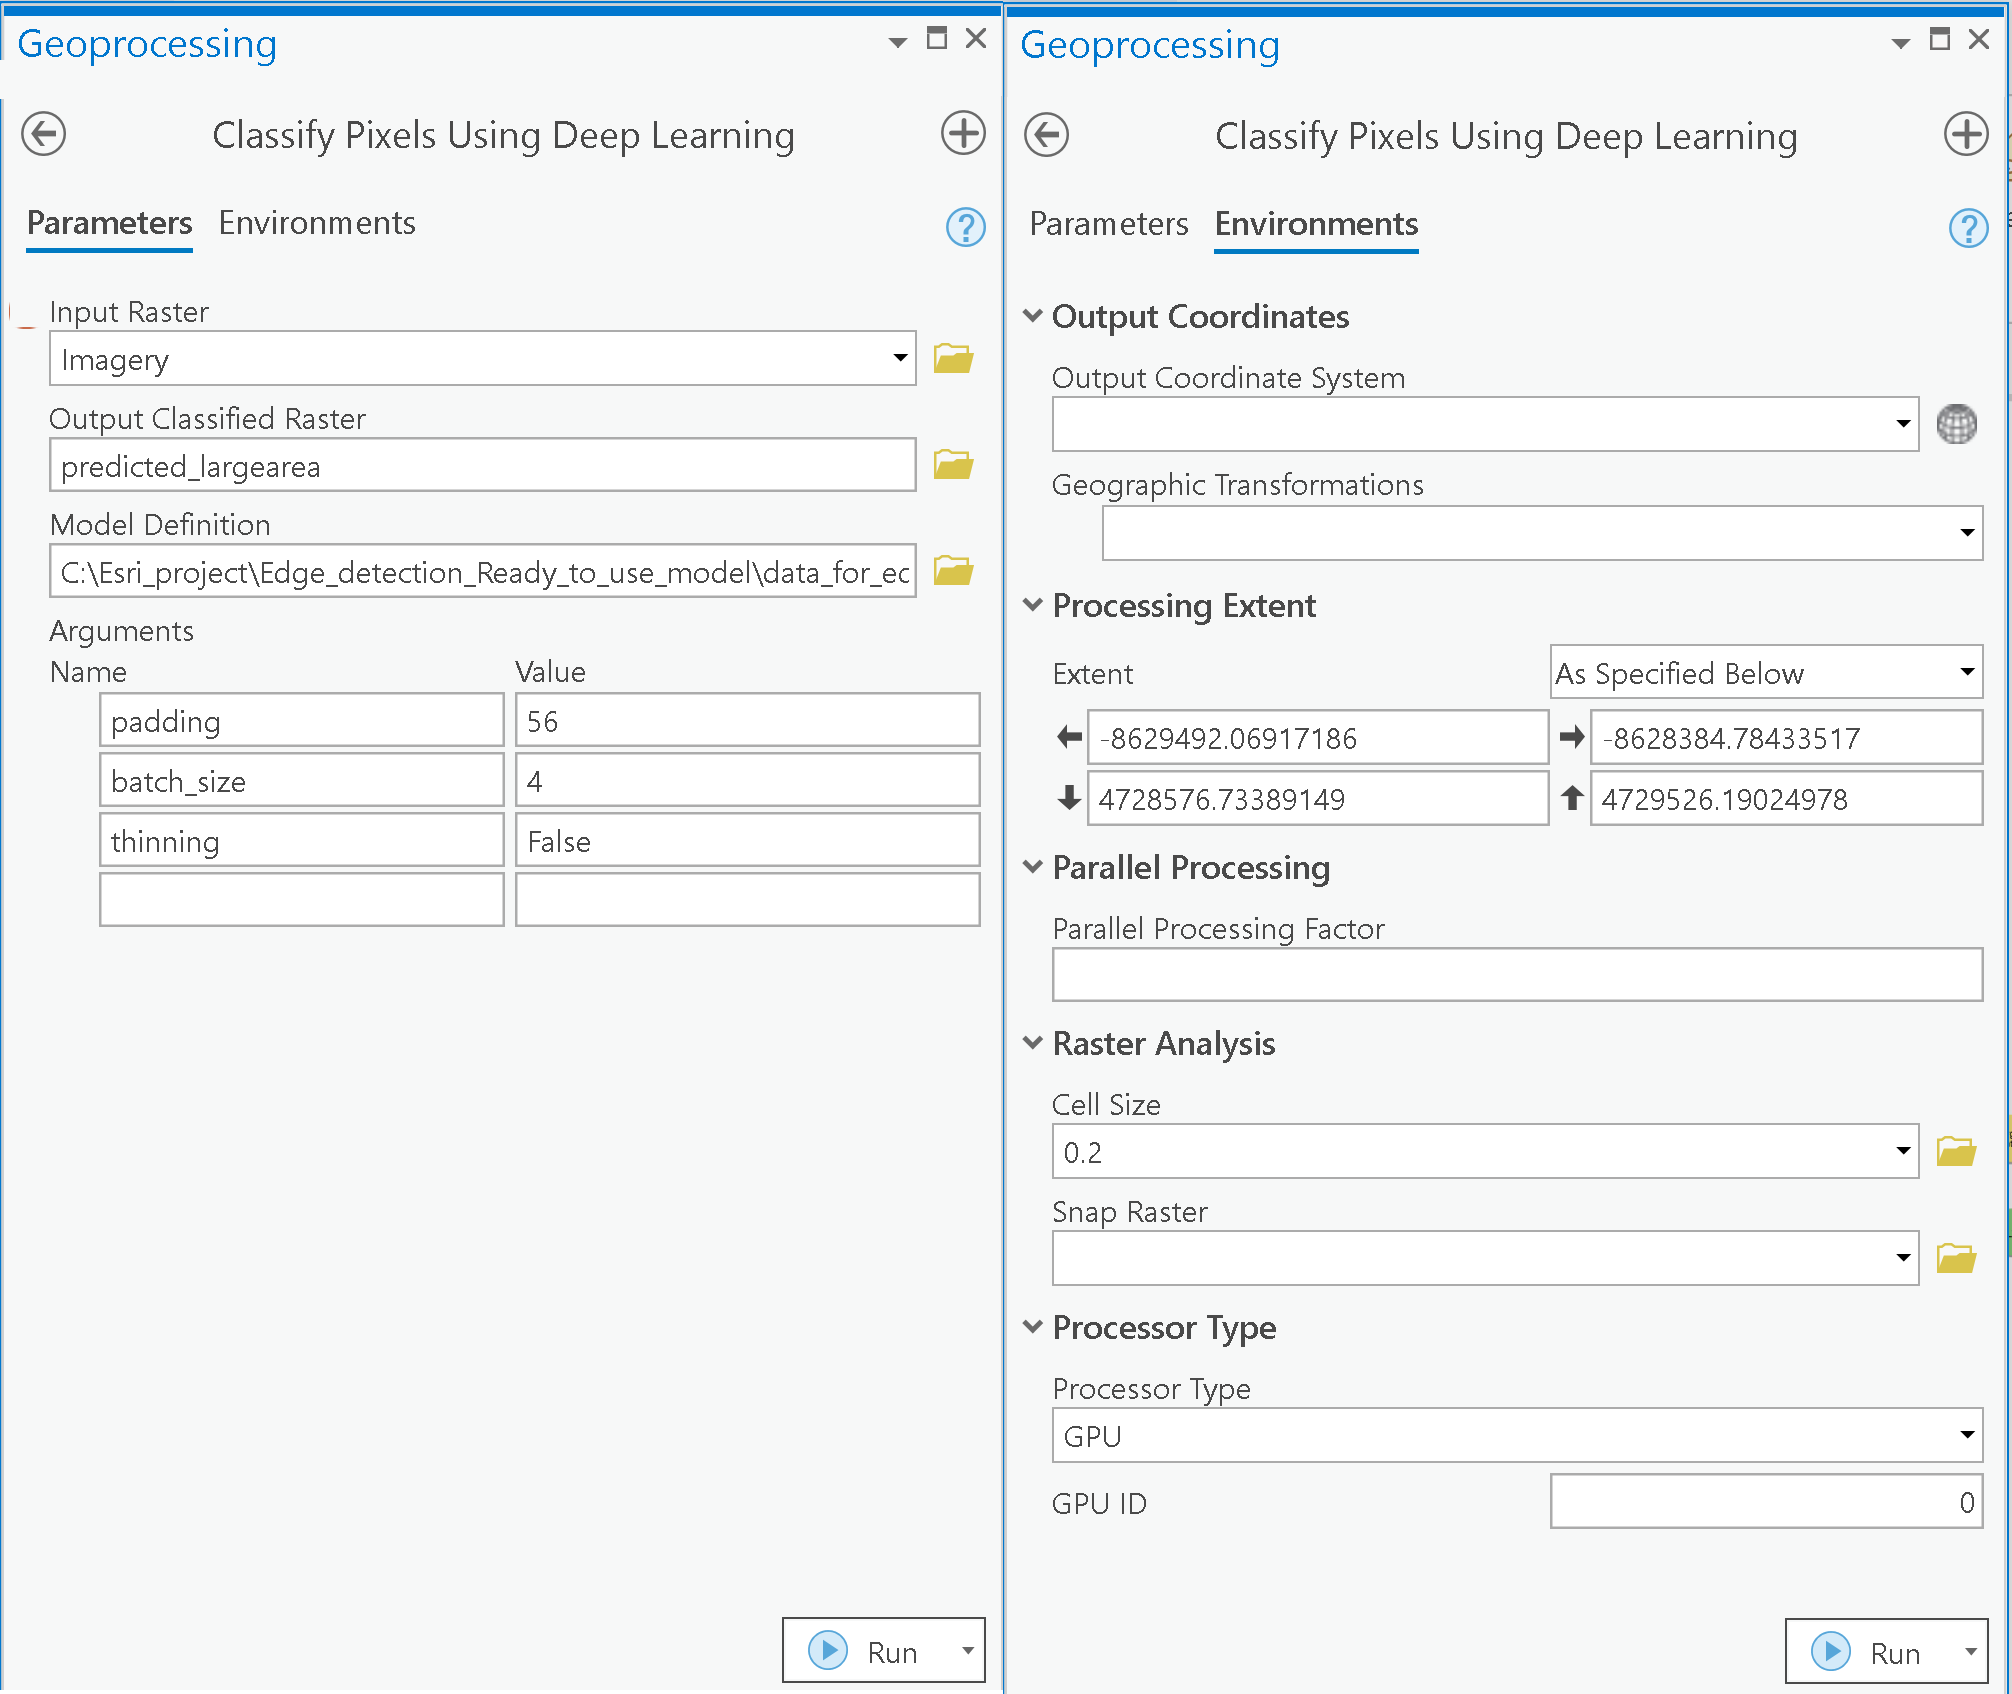

`out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("Imagery", r"C:\Esri_project\edge_detection_ready_to_use_model\models\edge_model_e30\edge_model_e100.emd", "padding 56;batch_size 4;thinning False"); 
out_classified_raster.save(r"C:\sample\sample.gdb\edge_detected")`

Output of this tool will be in form of a 'classified raster' containing both background and edges. For better visualization, the predicted raster is provided as a web map https://pythonapi.playground.esri.com/portal/home/webmap/viewer.html?webmap=35560c83171f4742847cdeffb813bad9&amp;extent=-77.5235,39.0508,-77.4729,39.0712

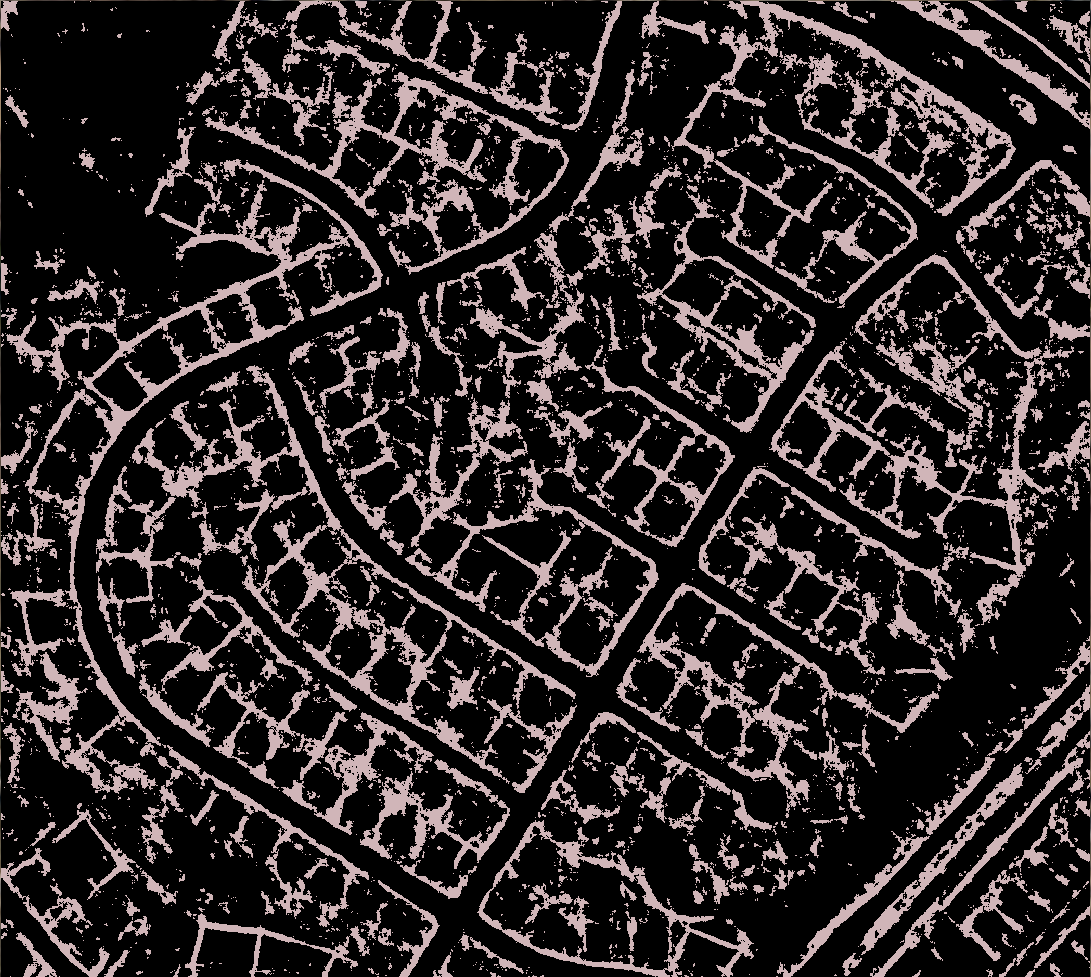

<center> A subset of predictions by trained model <center>

### Post-processing workflow using modelbuilder

As postprocessing workflow below involves geoprocessing tools and the parameters set in these tools need to be experimented with to get optimum results. We would use model builder to build this workflow for us and which will enable us to iteratively change the parameters in this workflow. The `Input raster` should be a predicted reclassified raster with 0-255 range pixel value.

Tools used and important parameters:

- `Input raster`: Predicted reclassified raster with 0-255 range pixel value. where 0:background and 255:edge.
- `Expand` : Expands specified zones of a raster by a specified number of cells. default value set for number of cells to 3.
- `Raster to polygon` : Vectorizes raster to polygon based on cell values, we will keep the 'Simplify Polygons' and 'Create Multipart Features' options unchecked.
- `Select by attribute` : Adds, updates, or removes a selection based on an attribute query. We try to filter out polygons with smaller area.
- `Simplify polygon` : Simplifies polygon outlines by removing relatively extraneous vertices while preserving essential shape. Simplification tolerance was set to 0.1.
- `Eliminate polygon parts` : Creates a new output feature class containing the features from the input polygons with some parts or holes of a specified size deleted. 'Condition' was set to 'area'.
- `Polygon to centerline` : Creates centerlines from polygon features. 
- `Simplify line` : Simplifies lines by removing relatively extraneous vertices while preserving essential shape. Simplification tolerance was set to 4.
- `Trim line` : Removes portions of a line that extend a specified distance past a line intersection (dangles). Dangle length was set to 100 and delete short features.
- `Feature to polygon` : Creates a feature class containing polygons generated from areas enclosed by input line or polygon features. 
- `Regularize building footprints` : This tool will produce the final finished results by shaping them to how actual buildings look. 'Method' for regularisation would be 'Right Angles and Diagonal' and the parameters 'tolerance', 'Densification' and 'Precision' are '1.5', '1', '0.25' and '2' respectively.
- `Simplify building` : Simplifies the boundary or footprint of building polygons while maintaining their essential shape and size.

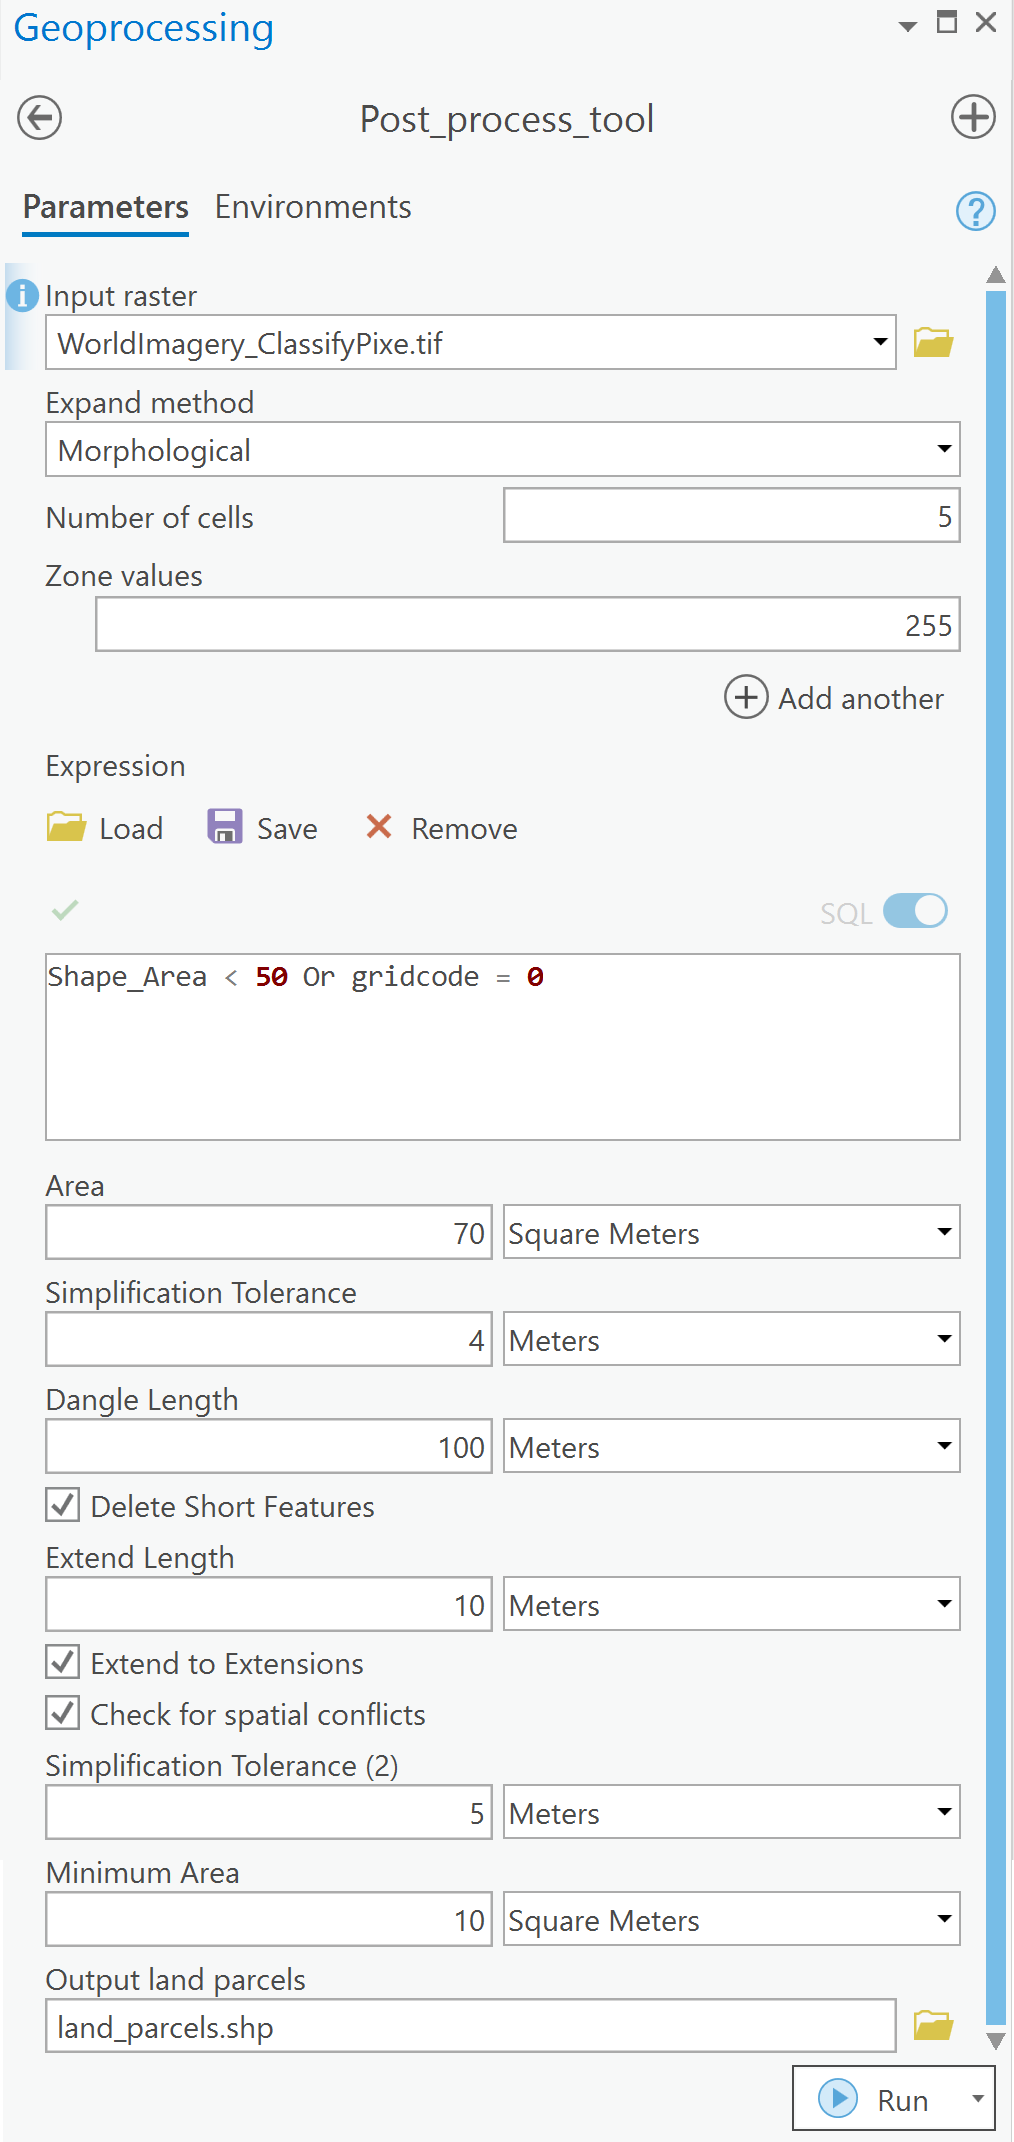

Attached below is the toolbox:

<Item title:"Geoprocessing tool for post-processing of results from edge detection deep learning model" type:Geoprocessing Sample owner:api_data_owner>
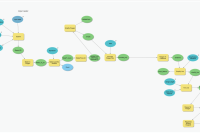

In [6]:
gis.content.get('9c8939622d954528916e0d6ffda4065d')

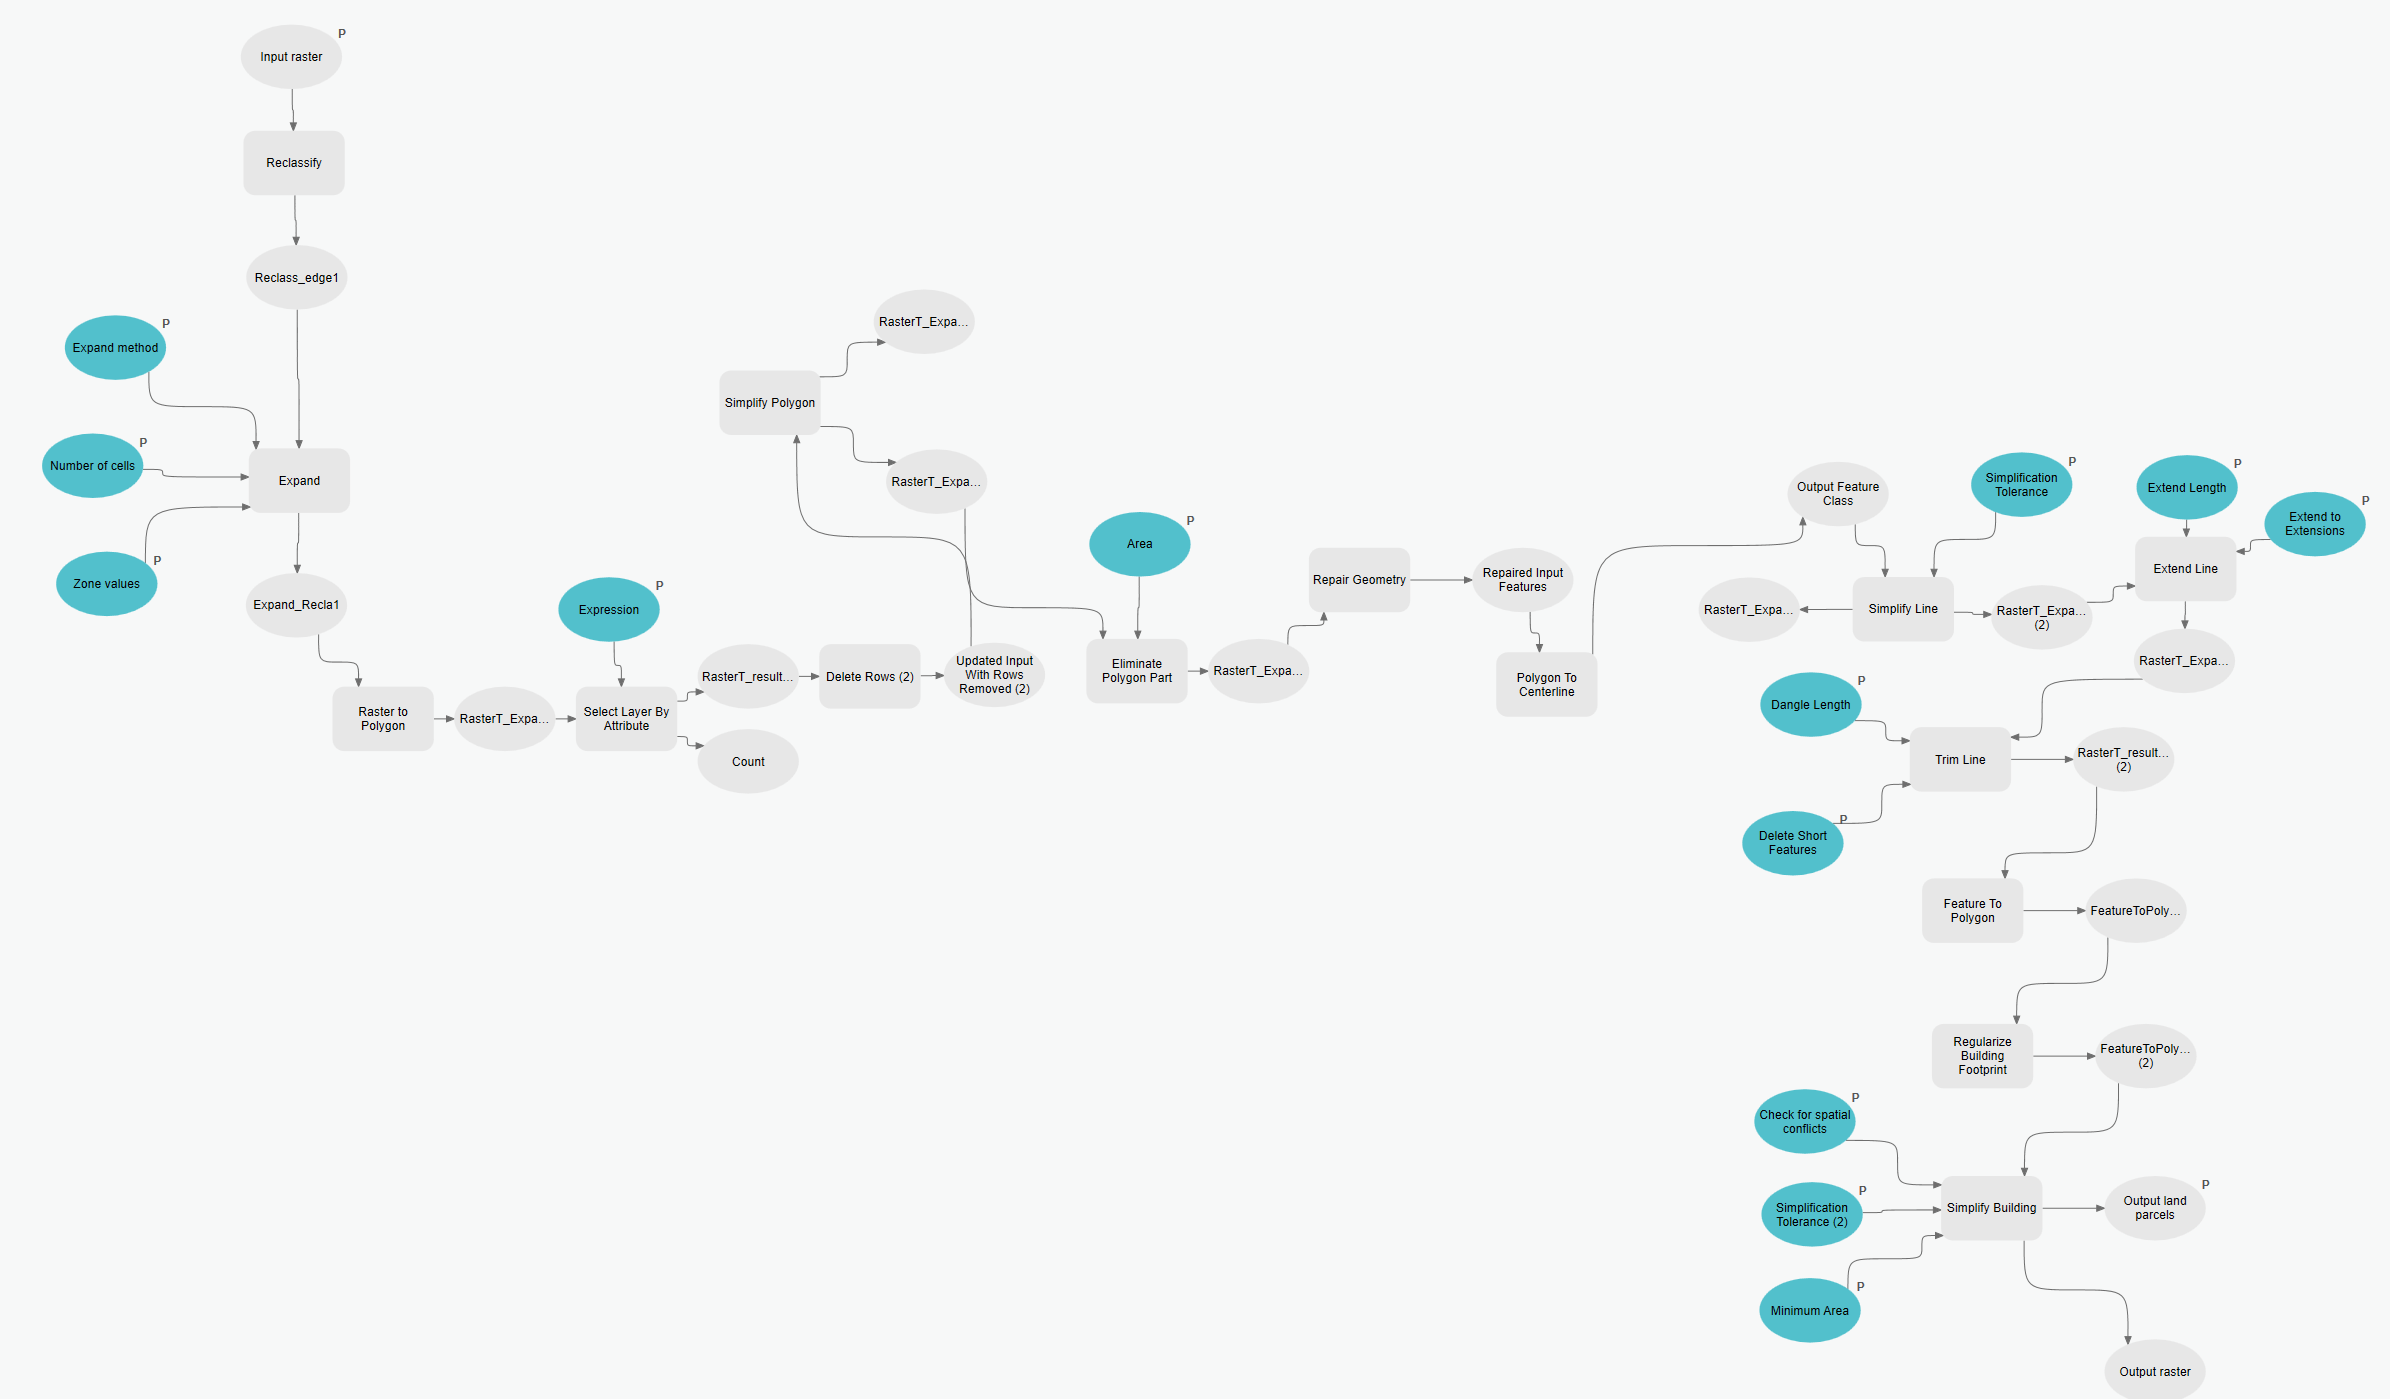

<center> Post-processing workflow in model builder <center>

### Final output

The final output will be in form of a feature class. A link to the web map is provided for better visualization of extracted parcels. Provided is a map for better visualization https://arcg.is/1u4LSX0.

<Item title:"Extracted land parcels" type:Feature Layer Collection owner:api_data_owner>
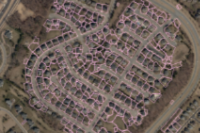

In [3]:
gis.content.get('f79515de95254eda83a0d3bc331bdcb7')

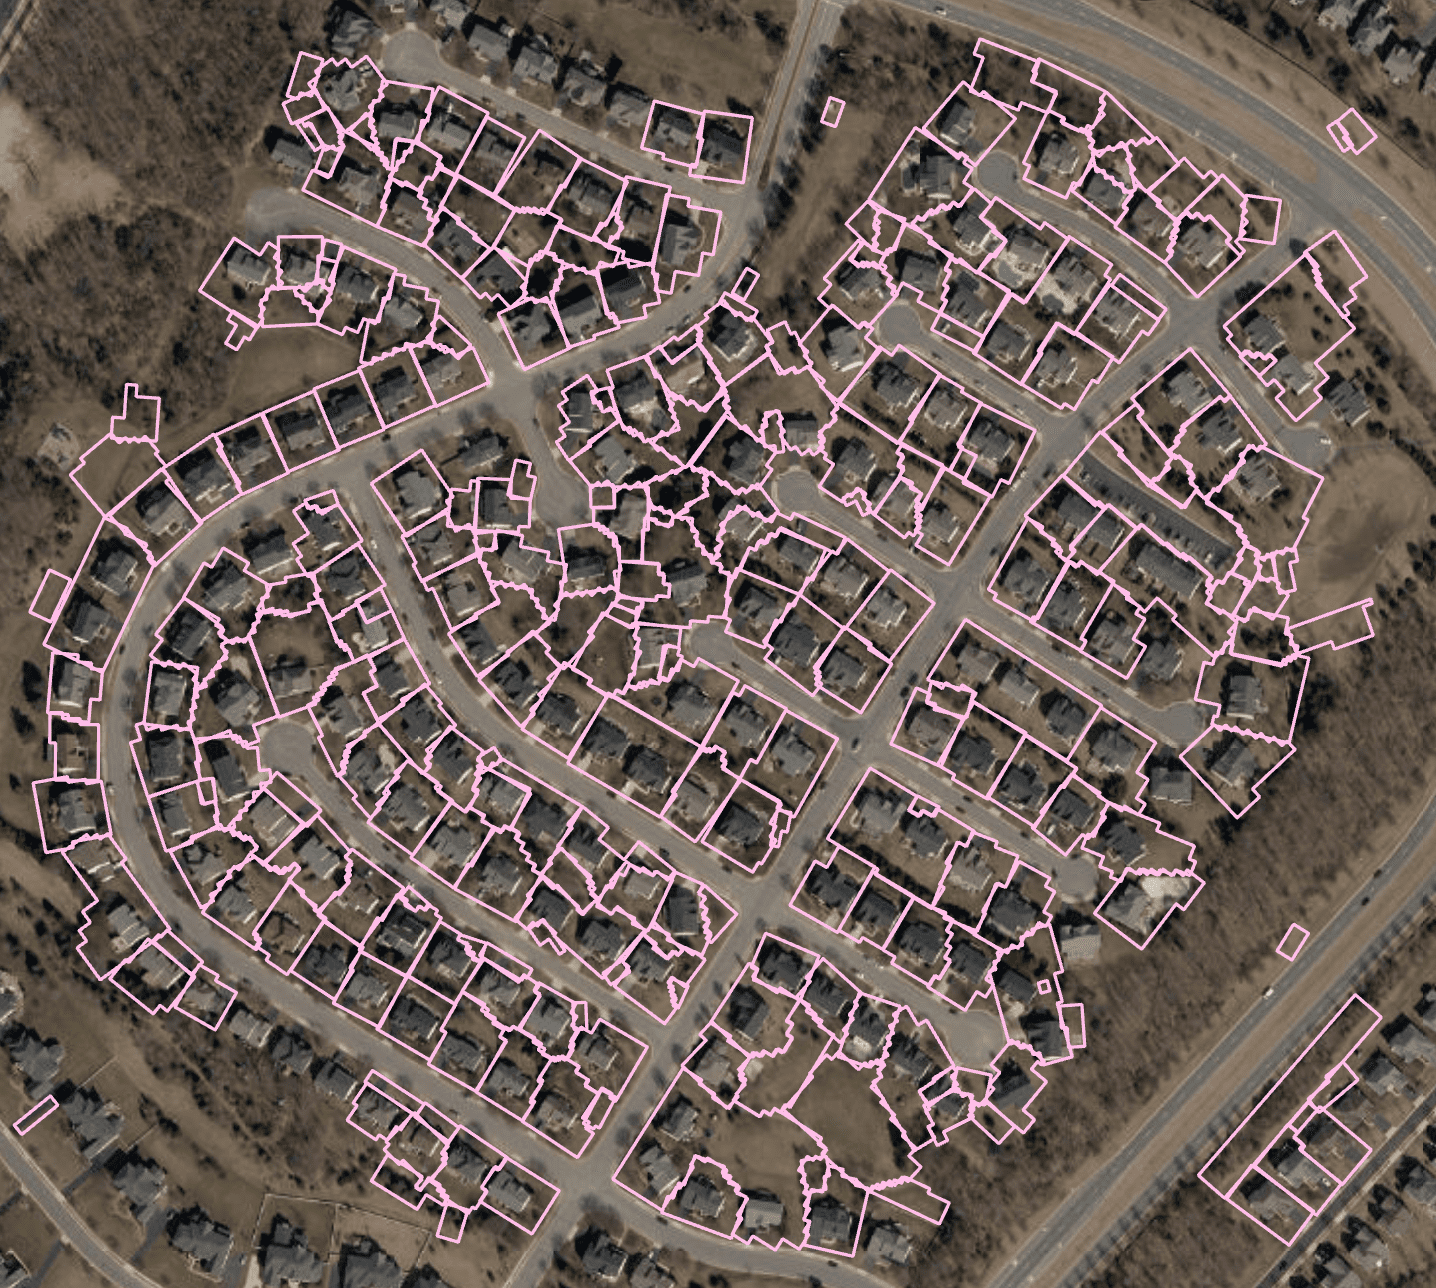

<center> A few subsets of results overlayed on the imagery <center>

## References

[1] He, Jianzhong, Shiliang Zhang, Ming Yang, Yanhu Shan, and Tiejun Huang. "Bi-directional cascade network for perceptual edge detection.", 2019; [https://arxiv.org/abs/1902.10903 arXiv:1902.10903v1].